### Dependencies

In [1]:
from utillity_script_cloud_segmentation import *

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [2]:
seed = 0
seed_everything(seed)
warnings.filterwarnings("ignore")

### Load data

In [3]:
submission = pd.read_csv('../input/understanding_cloud_organization/sample_submission.csv')
print('Test samples:', len(submission))

# Preprocecss data
submission['image'] = submission['Image_Label'].apply(lambda x: x.split('_')[0])
submission['label'] = submission['Image_Label'].apply(lambda x: x.split('_')[1])
test = pd.DataFrame(submission['image'].unique(), columns=['image'])

display(test.head())

Test samples: 14792


image
0  002f507.jpg
1  0035ae9.jpg
2  0038327.jpg
3  004f759.jpg
4  005ba08.jpg

# Model parameters

In [4]:
BACKBONE = 'densenet169'
CLASS_HEIGHT = 224
CLASS_WIDTH = 224
SEG_HEIGHT = 320
SEG_WIDTH = 480
CHANNELS = 3
N_CLASSES = 4
label_columns=['Fish', 'Flower', 'Gravel', 'Sugar']
best_tresholds_class = [0.82, 0.94, 0.84, 0.79]
best_tresholds_seg = [0.25, 0.5, 0.25, 0.15]
best_masks_seg = [22500, 20000, 20000, 12500]
best_tresholds_seg2 = [0.05, 0.15, 0.05, 0.1]
best_masks_seg2 = [0, 0, 20000, 0]

model_name = '38-[seg]65-UNetDenseNet169[class]19-EfficientNetB0.h5'
classification_model_path = '../input/cloud-seg-modelstoevaluate/19-EfficientNetB0_224x224_Cyclical_triangular.h5'
segmentation_model_fish_path = '../input/65-unet-densenet169-cosine-lr/65-unet_densenet169_320x480.h5'
segmentation_model_flower_path = '../input/65-unet-densenet169-flower-cosine-lr/65-unet_densenet169_320x480_Flower.h5'
segmentation_model_gravel_path = '../input/65-unet-densenet169-gravel-cosine-lr/65-unet_densenet169_320x480_Gravel.h5'
segmentation_model_sugar_path = '../input/65-unet-densenet169-sugar-cosine-lr/65-unet_densenet169_320x480_Sugar.h5'
test_images_path = '../input/cloud-images-resized-320x480/test_images320x480/test_images/'

In [5]:
preprocessing = sm.get_preprocessing(BACKBONE)

# Model

In [6]:
classification_model = load_model(classification_model_path)

segmentation_model_fish = load_model(segmentation_model_fish_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model_flower = load_model(segmentation_model_flower_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model_gravel = load_model(segmentation_model_gravel_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})
segmentation_model_sugar = load_model(segmentation_model_sugar_path, custom_objects={'AdamAccumulated':AdamAccumulated, 'binary_crossentropy_plus_dice_loss':sm.losses.bce_dice_loss, 'dice_coef':dice_coef, 'iou_score':sm.metrics.iou_score, 'f1-score':sm.metrics.f1_score})

segmentation_model_list = [segmentation_model_fish, segmentation_model_flower, segmentation_model_gravel, segmentation_model_sugar]

# Classification data generator

In [7]:
test_datagen=ImageDataGenerator(rescale=1./255.)

classification_test_generator=test_datagen.flow_from_dataframe(
                                            dataframe=test,
                                            directory=test_images_path,
                                            x_col="image",
                                            target_size=(CLASS_HEIGHT, CLASS_WIDTH),
                                            class_mode=None,
                                            batch_size=1,
                                            shuffle=False,
                                            seed=seed)

Found 3698 validated image filenames.


# Apply segmentation model to test set

In [8]:
for lbl_index, label in enumerate(label_columns):
  label_df = submission[submission['label'] == label]
  segmentation_model = segmentation_model_list[lbl_index]
  best_treshold_seg = best_tresholds_seg[lbl_index]
  best_mask_seg = best_masks_seg[lbl_index]
  best_treshold_seg2 = best_tresholds_seg2[lbl_index]
  best_mask_seg2 = best_masks_seg2[lbl_index]

  for i in range(0, label_df.shape[0], 500):
      batch_idx = list(range(i, min(label_df.shape[0], i + 500)))
      batch_set = label_df[batch_idx[0]: batch_idx[-1]+1]
      
      test_generator = DataGenerator(
                        directory=test_images_path,
                        dataframe=batch_set,
                        target_df=submission,
                        batch_size=1, 
                        target_size=(SEG_HEIGHT, SEG_WIDTH),
                        n_channels=CHANNELS,
                        n_classes=N_CLASSES,
                        preprocessing=preprocessing,
                        seed=seed,
                        mode='predict',
                        shuffle=False)
      
      preds = segmentation_model.predict_generator(test_generator)

      for index, row in enumerate(batch_set.itertuples(index=False)):
        file_name = getattr(row, 'Image_Label')
        pred_mask_raw = preds[index].astype('float32')
        pred_mask = post_process(pred_mask_raw, threshold=.5, min_size=0)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels'] = pred_rle
        ### Post procecssing
        pred_mask = post_process(pred_mask_raw, threshold=best_treshold_seg, min_size=best_mask_seg)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_post'] = pred_rle
        ### Post procecssing non-empty
        pred_mask = post_process(pred_mask_raw, threshold=best_treshold_seg2, min_size=best_mask_seg2)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_post2'] = pred_rle

# Using TTA Wrapper

In [9]:
segmentation_model_tta_list = []
for segmentation_model in segmentation_model_list:
  segmentation_model_tta_list.append(tta_segmentation(segmentation_model, h_flip=True, v_flip=True, merge='mean'))

### Apply segmentation model to test set (TTA)

In [10]:
for lbl_index, label in enumerate(label_columns):
  label_df = submission[submission['label'] == label]
  segmentation_model_tta = segmentation_model_tta_list[lbl_index]
  best_treshold_seg = best_tresholds_seg[lbl_index]
  best_mask_seg = best_masks_seg[lbl_index]
  best_treshold_seg2 = best_tresholds_seg2[lbl_index]
  best_mask_seg2 = best_masks_seg2[lbl_index]

  for i in range(0, label_df.shape[0], 500):
      batch_idx = list(range(i, min(label_df.shape[0], i + 500)))
      batch_set = label_df[batch_idx[0]: batch_idx[-1]+1]
      
      test_generator = DataGenerator(
                        directory=test_images_path,
                        dataframe=batch_set,
                        target_df=submission,
                        batch_size=1, 
                        target_size=(SEG_HEIGHT, SEG_WIDTH),
                        n_channels=CHANNELS,
                        n_classes=N_CLASSES,
                        preprocessing=preprocessing,
                        seed=seed,
                        mode='predict',
                        shuffle=False)
      
      preds = segmentation_model_tta.predict_generator(test_generator)

      for index, row in enumerate(batch_set.itertuples(index=False)):
        file_name = getattr(row, 'Image_Label')
        pred_mask_raw = preds[index].astype('float32')
        pred_mask = post_process(pred_mask_raw, threshold=.5, min_size=0)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_tta'] = pred_rle
        ### Post procecssing
        pred_mask = post_process(pred_mask_raw, threshold=best_treshold_seg, min_size=best_mask_seg)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_post_tta'] = pred_rle
        ### Post procecssing non-empty
        pred_mask = post_process(pred_mask_raw, threshold=best_treshold_seg2, min_size=best_mask_seg2)
        pred_rle = build_rles(pred_mask, reshape=(350, 525))
        submission.loc[submission['Image_Label'] == file_name, 'EncodedPixels_post2_tta'] = pred_rle

## Apply classifcation model to test set

In [11]:
test_class_preds = classification_model.predict_generator(classification_test_generator)

for index in range(len(label_columns)):
  test_class_preds[:,index] = (test_class_preds[:,index] > best_tresholds_class[index]).astype(int)
  
submission['empty_mask'] = test_class_preds.reshape(test_class_preds.shape[0]*N_CLASSES)
submission['EncodedPixels_post_class'] = submission.apply(lambda row: row['EncodedPixels_post'] if row['empty_mask'] == 0 else '', axis=1)
submission['EncodedPixels_post2_class'] = submission.apply(lambda row: row['EncodedPixels_post2'] if row['empty_mask'] == 0 else '', axis=1)
submission['EncodedPixels_post_class_tta'] = submission.apply(lambda row: row['EncodedPixels_post_tta'] if row['empty_mask'] == 0 else '', axis=1)
submission['EncodedPixels_post2_class_tta'] = submission.apply(lambda row: row['EncodedPixels_post2_tta'] if row['empty_mask'] == 0 else '', axis=1)

### Number of masks removed

In [12]:
for col in ['EncodedPixels_post', 'EncodedPixels_post2', 'EncodedPixels_post_tta', 'EncodedPixels_post2_tta']:
  print('Masks removed in "%s": %s' % (col, len(submission[(submission[col] == '') & (submission['empty_mask'] == 1)])))

Masks removed in "EncodedPixels_post": 1293
Masks removed in "EncodedPixels_post2": 689
Masks removed in "EncodedPixels_post_tta": 1293
Masks removed in "EncodedPixels_post2_tta": 711


### Inspecting some of the test set predictions

### Without post-process

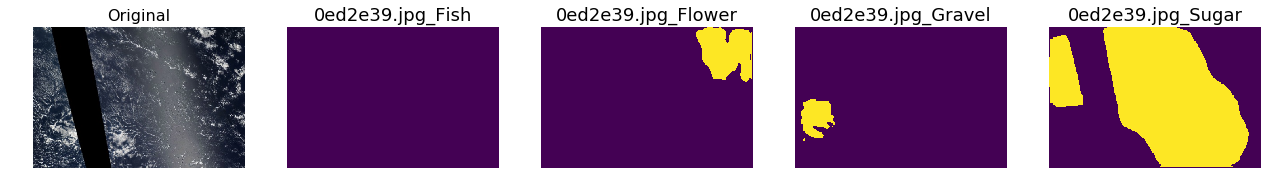

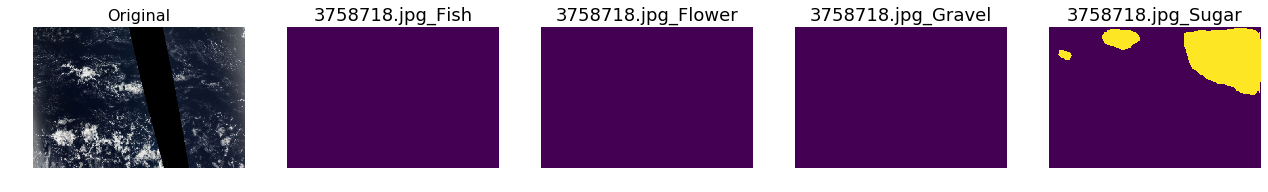

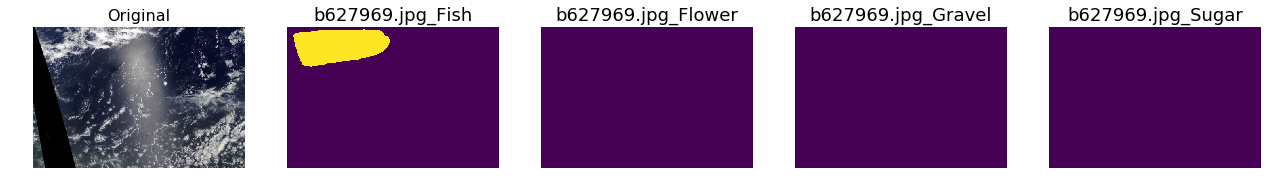

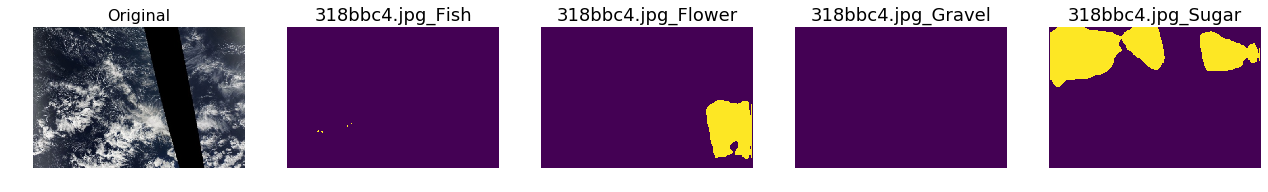

In [13]:
images_to_inspect_test =  np.random.choice(submission['image'].unique(), 4, replace=False)
inspect_predictions(submission, images_to_inspect_test, test_images_path)

### With post-process

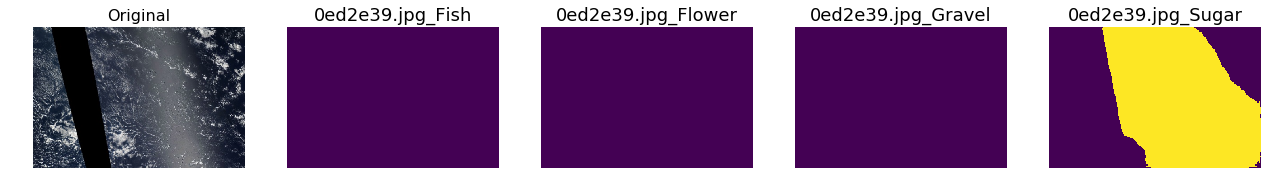

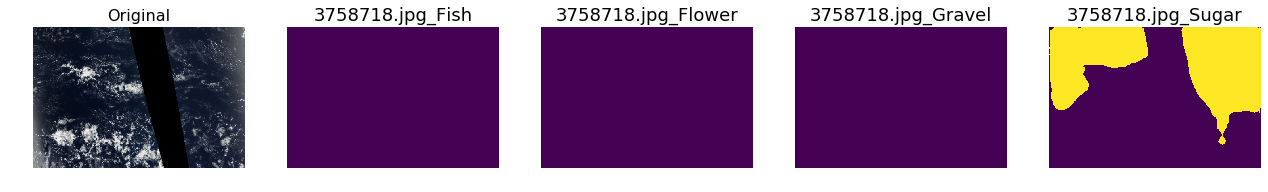

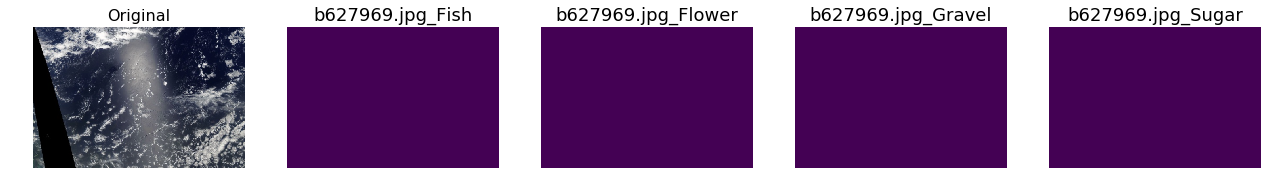

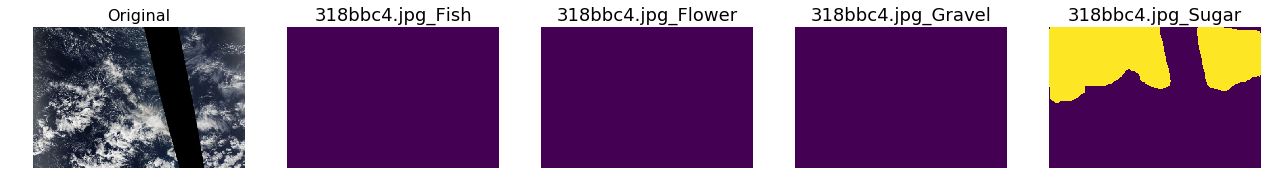

In [14]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post')

### With post-process non-empty masks

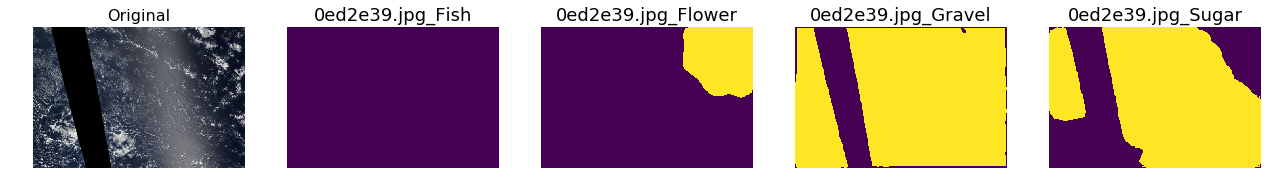

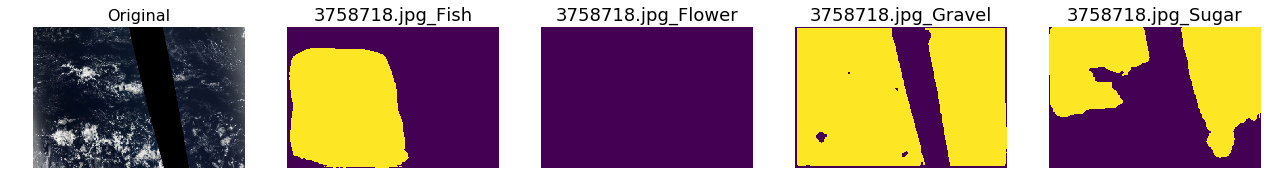

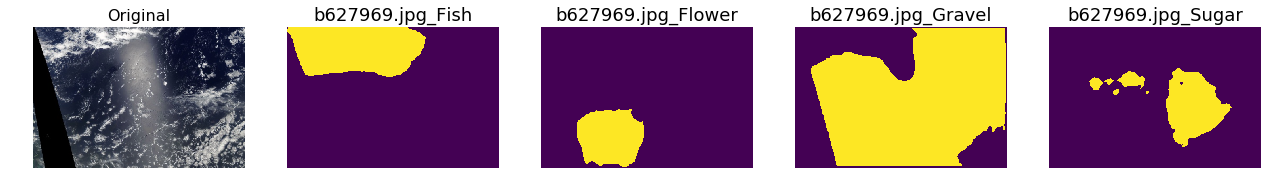

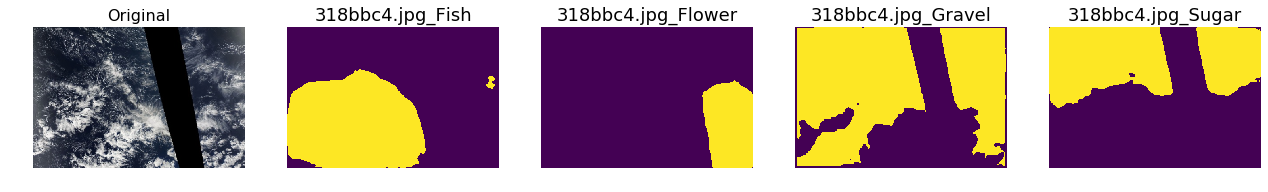

In [15]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post2')

### With post-process and mask classification

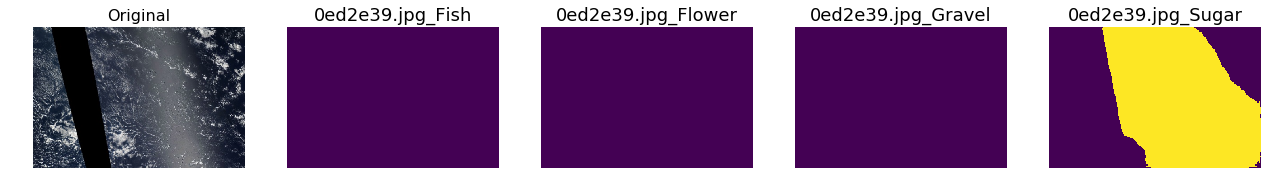

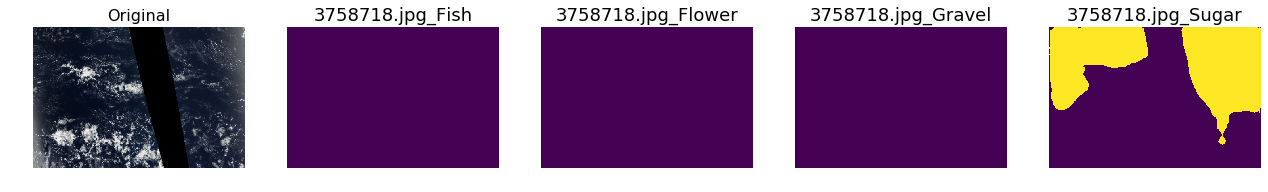

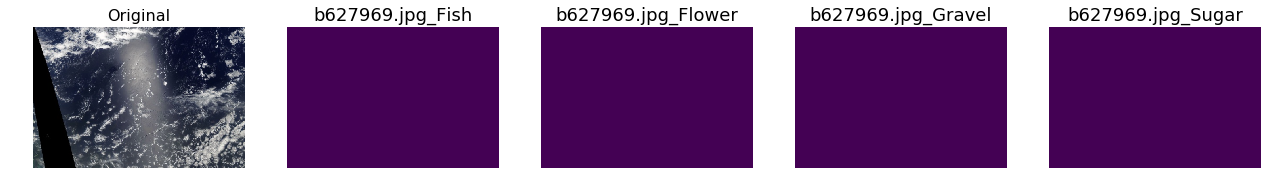

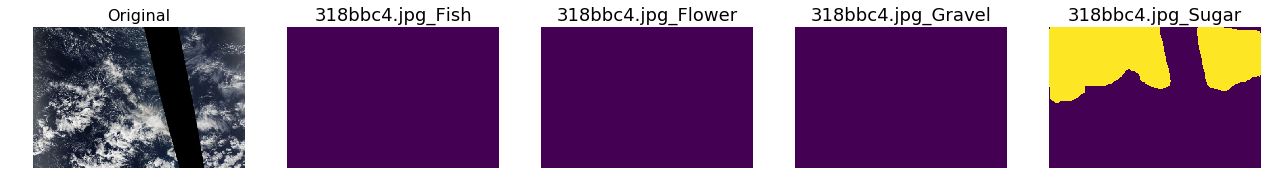

In [16]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_class')

### With post-process non-empty masks and mask classification

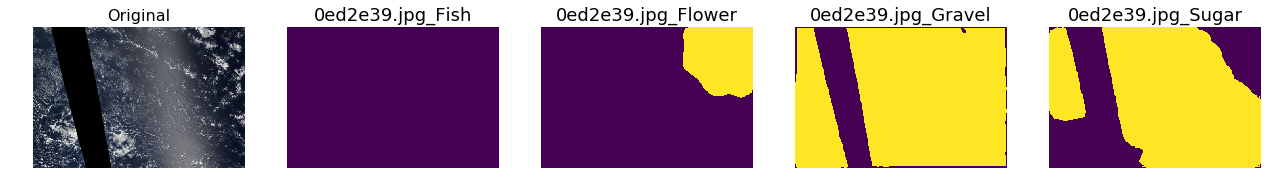

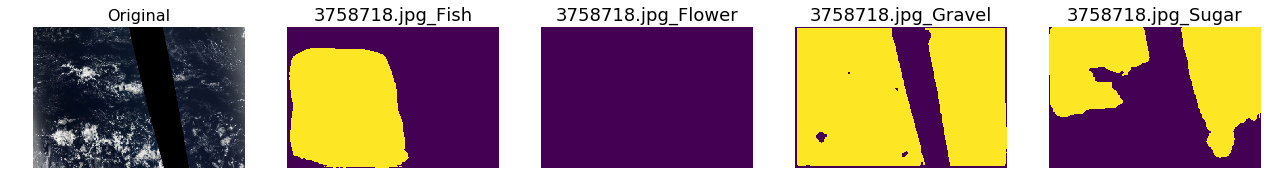

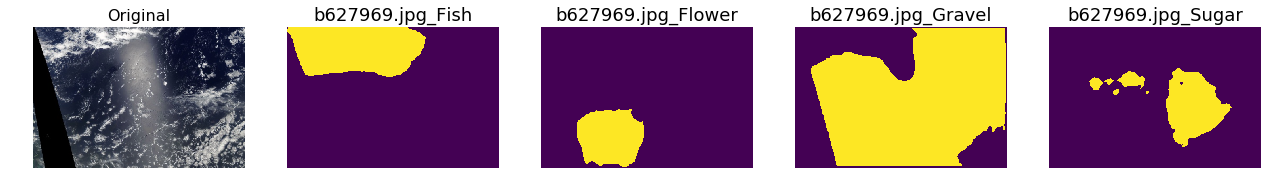

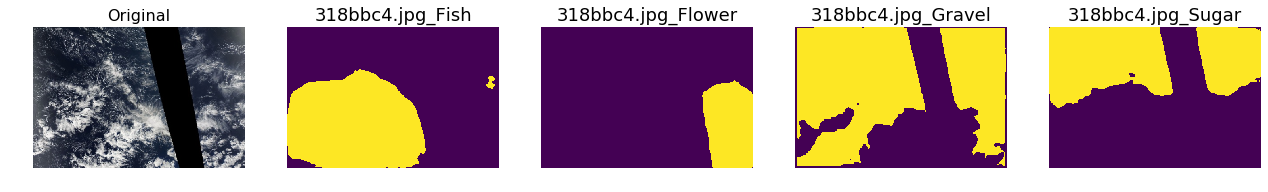

In [17]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post2_class')

### Without post-process and TTA

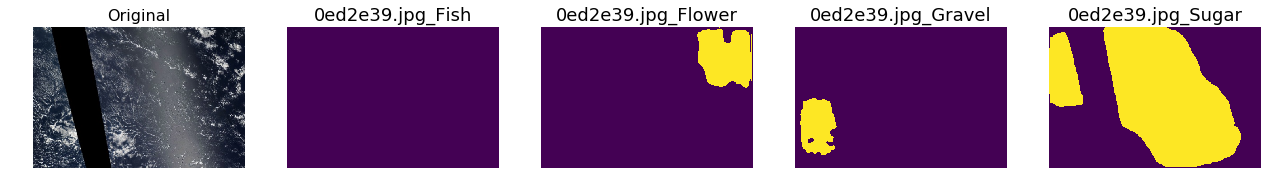

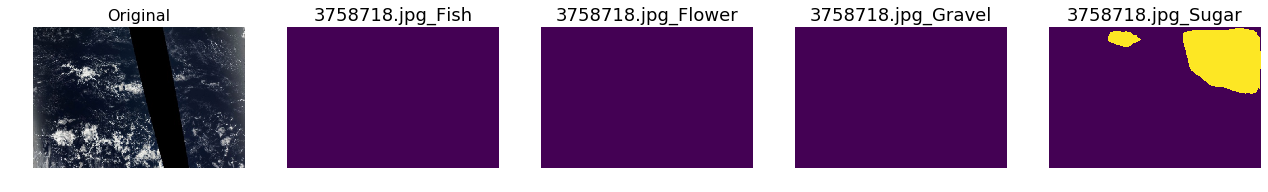

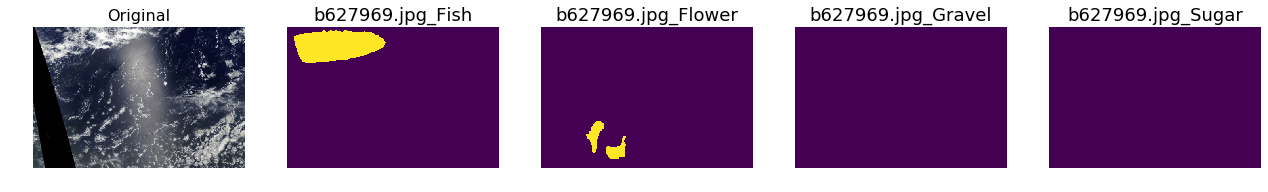

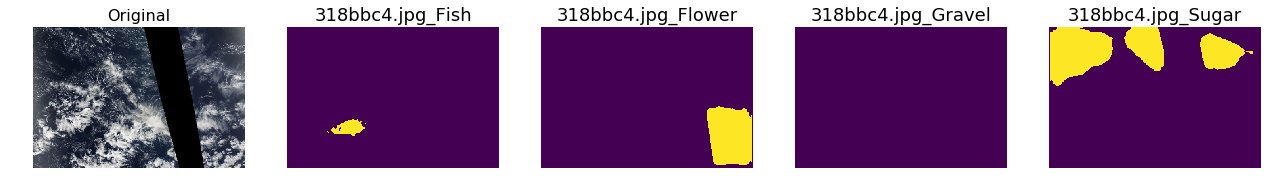

In [18]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_tta')

### With post-process and TTA

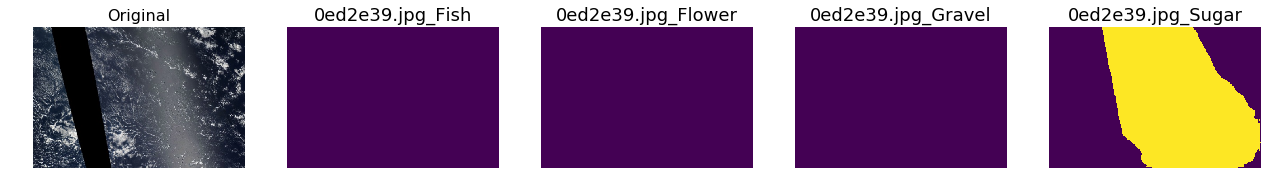

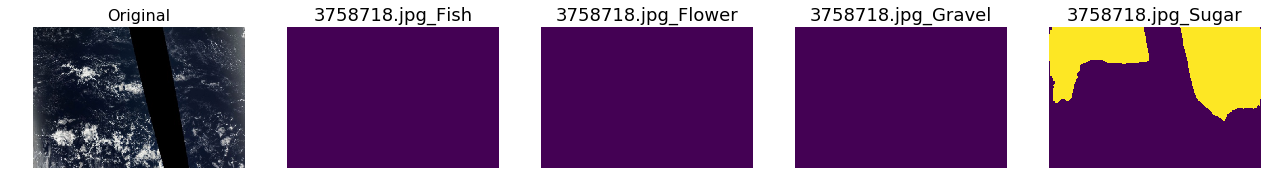

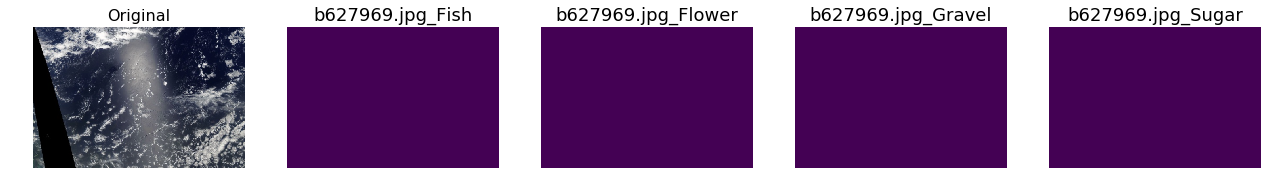

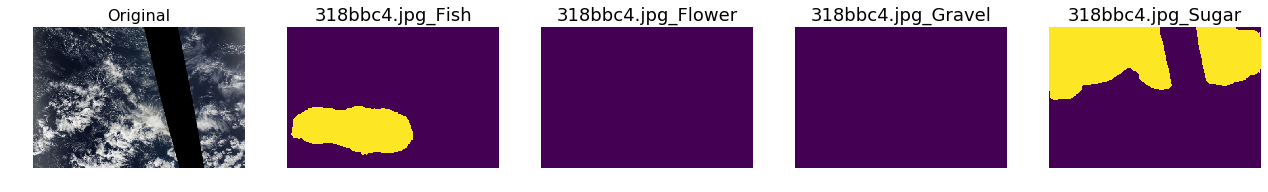

In [19]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_tta')

### With post-process non-empty and TTA

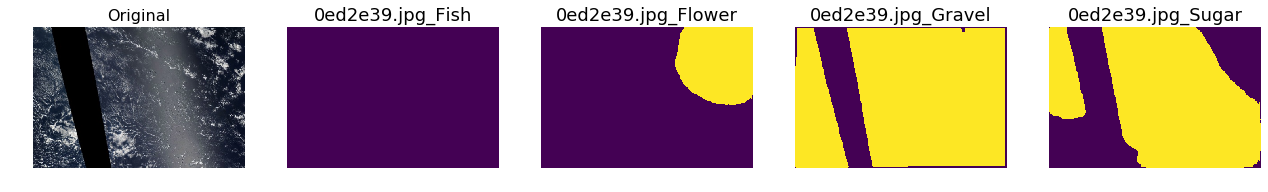

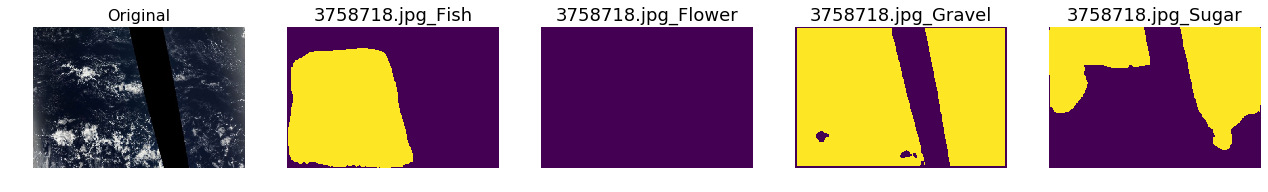

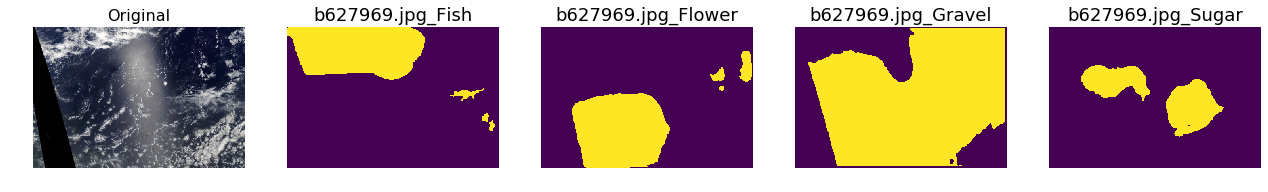

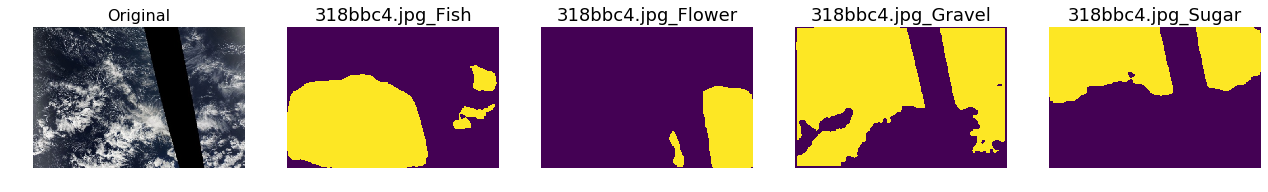

In [20]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post2_tta')

### With post-process and mask classification and mask classification

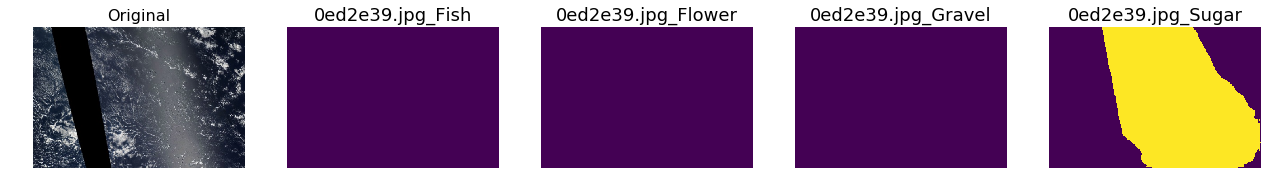

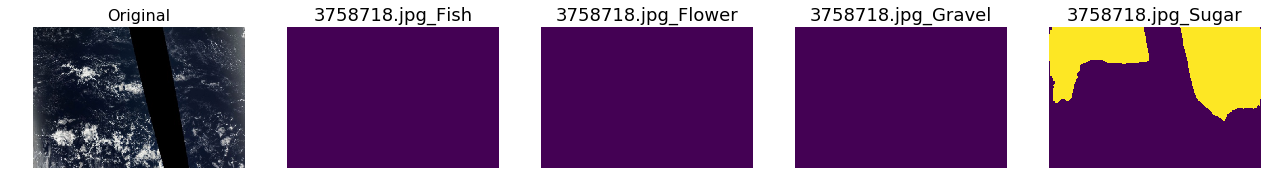

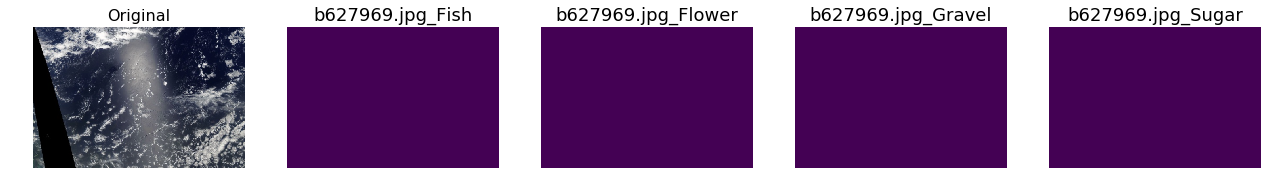

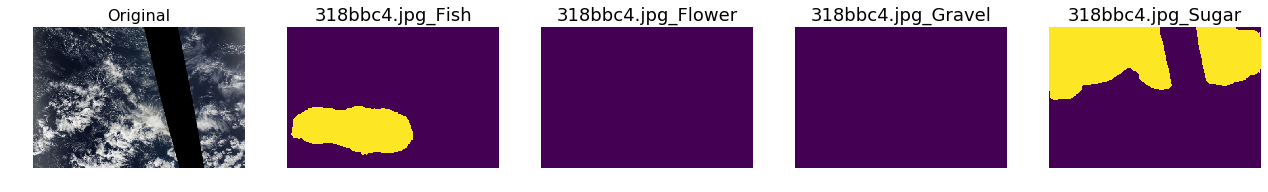

In [21]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post_class_tta')

### With post-process non-empty and mask classification and mask classification

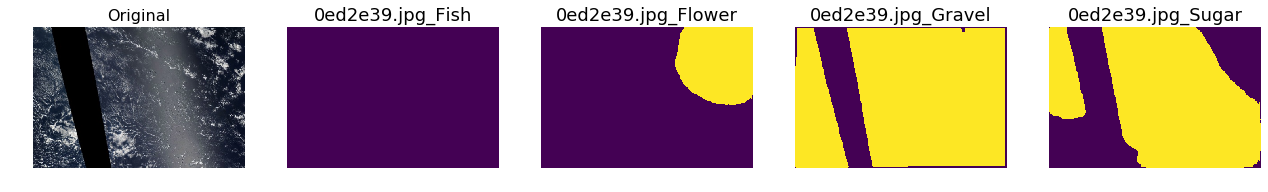

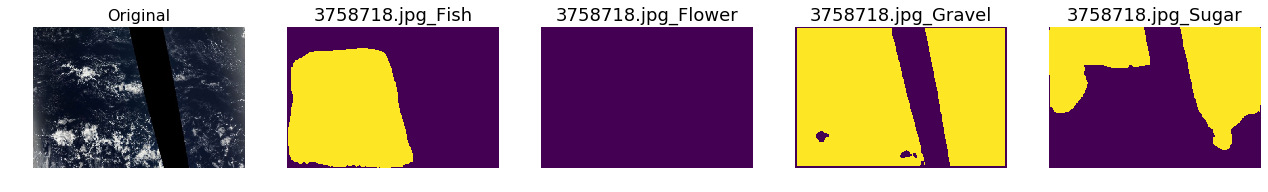

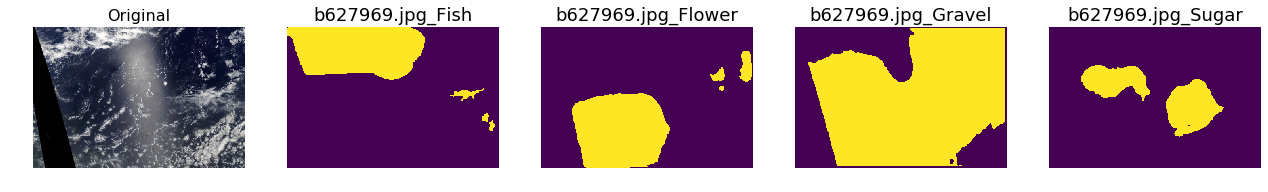

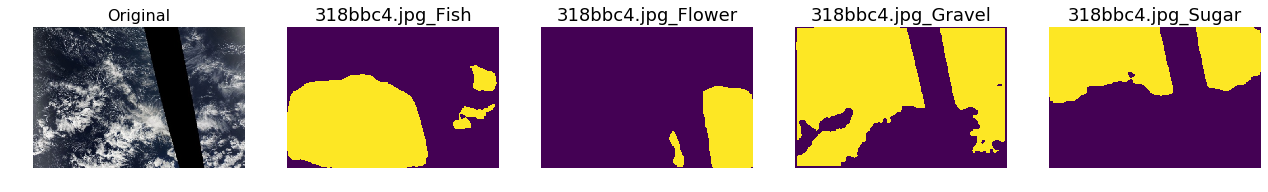

In [22]:
inspect_predictions(submission, images_to_inspect_test, test_images_path, label_col='EncodedPixels_post2_class_tta')

### Regular submission

In [23]:
# submission_df = submission[['Image_Label' ,'EncodedPixels']]
# submission_df.to_csv('submission.csv', index=False)
# display(submission_df.head())

### Submission with post processing

In [24]:
# submission_df = submission[['Image_Label' ,'EncodedPixels_post']]
# submission_df.columns = ['Image_Label' ,'EncodedPixels']
# submission_df.to_csv('submission_post.csv', index=False)
# display(submission_df.head())

### Submission with post processing non-empty masks 

In [25]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post2']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post2.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  48247 2 48596 6 48927 28 49277 28 49625 31 499...
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1 66497 66500 348 66850 348 67200 348 67550 34...
3   002f507.jpg_Sugar  29 180 385 160 735 160 1067 201 1415 205 1766 ...
4    0035ae9.jpg_Fish  350 1 86595 3 86943 6 87290 10 87638 12 87986 ...

### Submission with post processing and mask classification

In [26]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post_class.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  11 323 361 319 711 319 1055 342 1404 344 1754 ...
3   002f507.jpg_Sugar  66 117 416 117 757 130 1079 179 1427 183 1777 ...
4    0035ae9.jpg_Fish

### Submission with post processing non-empty masks and mask classification

In [27]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post2_class']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post2_class.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  48247 2 48596 6 48927 28 49277 28 49625 31 499...
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1 66497 66500 348 66850 348 67200 348 67550 34...
3   002f507.jpg_Sugar  29 180 385 160 735 160 1067 201 1415 205 1766 ...
4    0035ae9.jpg_Fish  350 1 86595 3 86943 6 87290 10 87638 12 87986 ...

### Submission without post processing and TTA

In [28]:
submission_df = submission[['Image_Label' ,'EncodedPixels_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_tta.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  117 5 134 16 467 5 484 16 731 221 966 4 1065 3...
3   002f507.jpg_Sugar  3602 6 3946 15 3987 3 4001 1 4296 15 4337 3 43...
4    0035ae9.jpg_Fish

### Submission with post processing and TTA

In [29]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post_tta.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  8 333 359 332 709 332 1054 344 1404 344 1754 3...
3   002f507.jpg_Sugar  30 160 380 160 730 161 1066 191 1416 191 1769 ...
4    0035ae9.jpg_Fish

### Submission with post processing non-empty masks and TTA

In [30]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post2_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post2_tta.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  47191 6 47539 10 47887 14 48229 24 48576 30 48...
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1 69297 69300 348 69650 348 70000 348 70350 34...
3   002f507.jpg_Sugar  14 196 367 189 717 189 1061 206 1410 208 1761 ...
4    0035ae9.jpg_Fish  350 1 74291 4 74639 7 74988 7 75337 6 75686 6 ...

### Submission with post processing and TTA and mask classification

In [31]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post_class_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post_class_tta.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish                                                   
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  8 333 359 332 709 332 1054 344 1404 344 1754 3...
3   002f507.jpg_Sugar  30 160 380 160 730 161 1066 191 1416 191 1769 ...
4    0035ae9.jpg_Fish

### Submission with post processing non-empty masks and TTA and mask classification

In [32]:
submission_df = submission[['Image_Label' ,'EncodedPixels_post2_class_tta']]
submission_df.columns = ['Image_Label' ,'EncodedPixels']
submission_df.to_csv('submission_post2_class_tta.csv', index=False)
display(submission_df.head())

Image_Label                                      EncodedPixels
0    002f507.jpg_Fish  47191 6 47539 10 47887 14 48229 24 48576 30 48...
1  002f507.jpg_Flower                                                   
2  002f507.jpg_Gravel  1 69297 69300 348 69650 348 70000 348 70350 34...
3   002f507.jpg_Sugar  14 196 367 189 717 189 1061 206 1410 208 1761 ...
4    0035ae9.jpg_Fish  350 1 74291 4 74639 7 74988 7 75337 6 75686 6 ...